# Feature Preparation Notebook

**Related to Figure 4, Figure 5 and Supplemental Figure 2**  

Figures Generated:
- SFig 2A - feature correlations

Data generated:
- Supplemental Table 3


### Set Up

In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import sklearn.preprocessing as prep
import statsmodels.api as sm

import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [44]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

In [45]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

### Load initial data

In [47]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [48]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
best_df = coloc_df[coloc_df['Optimal COLOC']].copy()

In [49]:
all_pairs = coloc_df.trait_pair.values

In [50]:
best_pairs = best_df.trait_pair.values

## Biological Features

In [53]:
bio_df = pd.read_csv(os.path.join(datadir, 'outputs/Raw_geneset_gene_features.txt'), sep='\t', index_col=0)
bio_df = bio_df.loc[:,[ 'pli', 'Length', 'GO', 'n_mrna', 'mrna', 'Set'] ]
bio_df.columns = ['LOEUF', 'GeneSize', 'GO','nTissues', 'mRNA', 'Set']

In [54]:
bio_df.head()

,LOEUF,GeneSize,GO,nTissues,mRNA,Set
34244158_MONDO_0004986,1.10035,64007.0,12.0,52.0,5.073262,Rare
34375979_MONDO_0005277,1.16710,40270.0,11.0,53.0,9.957110,Rare
32492392_EFO_0001073,2.98230,54188.5,17.0,54.0,9.936466,Rare
34226706_EFO_0004570,1.61325,60393.0,17.0,7.0,1.057579,Rare
30175238_EFO_0004312,0.51479,18959.0,14.0,37.0,8.706008,Rare


## Study & Study Design Features

In [96]:
study_info = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t',
                        usecols=['Mapped EFO', 'Study Identifier', 'Variant Type', 'Population Sample Size', 'Gene Count',
                                'Trait Type', 'Biological Domain', 'Mapped Trait'])
study_info.columns = ['TRAIT', 'EFO', 'Study', 'Set', 'trait_type', 'Domain', 'N', 'g' ]
study_info['StudyTrait'] = study_info['Study'] + '_' + study_info['EFO']
info_df = study_info.copy()

,TRAIT,EFO,Study,Set,trait_type,Domain,N,g,StudyTrait
0,neutrophil count,EFO_0004833,34226706,Rare,Continuous,Immunological,443782.0,22,34226706_EFO_0004833


In [97]:
coloc_feat = coloc_df.loc[:, ['EFO', 'Trait', 'Common Study', 'Rare Study', 'nCommon', 'nRare', 'nShared', 'Log2SizeOE', 
                              'trait_pair']]

In [109]:
coloc_feat.columns

Index(['EFO', 'Trait', 'Common Study', 'Rare Study', 'nCommon', 'nRare',
       'nShared', 'Log2SizeOE', 'trait_pair'],
      dtype='object')

In [110]:
info_df.columns

Index(['TRAIT', 'EFO', 'Study', 'Set', 'trait_type', 'Domain', 'N', 'g',
       'StudyTrait'],
      dtype='object')

In [98]:
rare_info = info_df[info_df.Set=='Rare'].loc[:, ('Study', 'N', 'g', 'EFO', "TRAIT")].drop_duplicates()
rare_info['Study'] = rare_info['Study'].astype(int)
input_df = coloc_feat.merge(rare_info, 
                           left_on=['EFO', 'Trait', 'Rare Study'], right_on=['EFO', 'TRAIT', 'Study'], how='left')
input_df.shape

(1689, 13)

In [113]:
input_df = pd.read_csv(os.path.join(datadir, 'outputs/Raw_input_features.txt'), sep='\t')
input_df.shape

(1634, 17)

## Network Features

In [114]:
# Load network results
net = []
not_found = 0
for pair in best_pairs:
    try:
        x = pd.read_csv(os.path.join(nrnb_dir, 'outputs/Features/network_stats', f'network_stats_pcnet2_0_best_rare.traitlist.{pair}'), sep='\t', low_memory=False)
        net.append(x)
    except FileNotFoundError:
        not_found +=1
        #print(f'{pair} not found')
print(not_found)
for pair in all_pairs:
    if pair not in best_pairs:
        try:
            x = pd.read_csv(os.path.join(nrnb_dir, 'outputs/Features/network_stats', f'network_stats_pcnet2_0_not_best_rare.traitlist.{pair}'), sep='\t', low_memory=False)
            net.append(x)
        except FileNotFoundError:
            try:
                x = pd.read_csv(os.path.join(nrnb_dir, 'outputs/Features/network_stats', f'network_stats_pcnet2_0_not_best_rare.traitlist.{pair.replace("_EFO", ".0_EFO")}'), sep='\t', low_memory=False)
                net.append(x)
            except FileNotFoundError:
                not_found+=1
            #print(f'{pair} not found')
print(not_found)
print('Completion:', (1 - not_found/1261))

0
0
Completion: 1.0


In [115]:
netdf = pd.concat(net)

In [116]:
def extract_subAssort(instr):
    outstr = instr.replace('(', '').replace(')', '').split(', ')
    return [float(x) for x in outstr] 

In [117]:
rc_assortativity = netdf.loc[netdf.varset=='rare_common', ( 'trait', 'varset', 'subnetwork_assortativity')]
rc_assortativity['subnetAssort'] = rc_assortativity.subnetwork_assortativity.apply(lambda x:x if isinstance(x, float) else np.mean(extract_subAssort(x)))

In [118]:
net_df = netdf.drop(columns='subnetwork_assortativity').merge(rc_assortativity.drop(columns='subnetwork_assortativity'), on=['trait', 'varset'], how='left')

In [119]:
net_df.head()

,trait,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetAssort
0,34662886_EFO_0000095_GCST002073_EFO_0000095,rare,0.333333,2,1872.250000,1.000000,0.264898,0.000000,-0.000438,1.666667,NaN
1,34662886_EFO_0000095_GCST002073_EFO_0000095,common,0.333333,2,420.111111,2.666667,0.309568,0.500000,0.005860,1.722222,NaN
2,34662886_EFO_0000095_GCST002073_EFO_0000095,overlap,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,34662886_EFO_0000095_GCST002073_EFO_0000095,rare_common,0.243590,1,866.923077,2.923077,0.289263,0.307692,0.001912,1.794872,0.272031
4,34375979_EFO_0000096_GCST002643_EFO_0000096,rare,0.071429,6,657.375000,0.500000,0.311598,0.000000,0.000078,2.250000,NaN


In [120]:
info_df.head()

,TRAIT,EFO,Study,Set,trait_type,Domain,N,g,StudyTrait
0,neutrophil count,EFO_0004833,34226706,Rare,Continuous,Immunological,443782.000000,22,34226706_EFO_0004833
1,neutrophil count,EFO_0004833,34662886,Rare,Continuous,Immunological,418407.159091,16,34662886_EFO_0004833
2,neutrophil count,EFO_0004833,28089252,Rare,Continuous,Immunological,1860.000000,7,28089252_EFO_0004833
3,autism spectrum disorder,EFO_0003756,24151499,Rare,Categorical,Psychiatric,1657.000000,12,24151499_EFO_0003756
4,autism spectrum disorder,EFO_0003756,35982160,Rare,Categorical,Psychiatric,63237.000000,119,35982160_EFO_0003756


In [123]:
net_df = net_df.merge(input_df.loc[:, ('n_rare', 'n_common', 'n_overlap', 'trait_pair')], 
                      left_on='trait', right_on='trait_pair').drop(columns='trait')

In [124]:
subnets = net_df.pivot(index='trait_pair', columns='varset', values='subnetwork_density')

In [125]:
net_df.to_csv(os.path.join(datadir, 'outputs/Raw_network_features.txt'), sep='\t')

## Trait Features

### Heritability

In [126]:
ukb_df = pd.read_csv(os.path.join(datadir,'Reference_Data/ukb31063_h2_topline.02Oct2019.tsv.gz'), sep='\t')

In [127]:
# exclude pigmentation and bilirubin 
# (as per https://nealelab.github.io/UKBB_ldsc/confidence.html#unusually_large_standard_errors)
exclude = ['1717', '1727', '1747_1','1747_2','1747_3', '1747_4', '1747_5','1747_6', '30660_irnt', '30840_irnt']

In [128]:
ukb_df = ukb_df[(~ukb_df.phenotype.isin(exclude)) & (~ukb_df.isBadOrdinal)]

#### Trait matching

In [129]:
ukb = model.encode(ukb_df.description.values, batch_size=32)
efo = model.encode(domain_info.TRAIT.values, batch_size=32)
cosines = cosine_similarity(ukb, efo)

In [130]:
results = []
for i in range(373):
    best = np.argmax(cosines[:, i])
    results.append((domain_info.TRAIT.values[i], ukb_df.description.values[best], cosines[best, i]))

Perform manual curation

In [131]:
pd.DataFrame(results, columns=['EFO', 'UKB', 'Cosine']).to_csv(os.path.join(datadir, 'outputs/heritability_data_match.tsv'), sep='\t')

In [136]:
matches = pd.read_csv(os.path.join(datadir, 'outputs/Heritability match - Sheet1.tsv'), sep='\t', index_col=0)

In [137]:
matches = matches[matches.Keep==1]
matched_EFO = domain_info[domain_info.TRAIT.isin(matches.EFO.values)]
matches = matches.rename(columns={'EFO':'TRAIT', 'UKB':'description'})

In [138]:
h_df = ukb_df[ukb_df.description.isin(matches.description.values)]
h_df = h_df.merge(matches, on='description', how='left')
h_df = h_df.merge(matched_EFO, on=[ 'TRAIT'], how='left')
# duplicate UKB traits
h_df = h_df[~h_df.phenotype.isin(['23104_irnt', '23098_irnt'])]

In [139]:
h_df.shape

(197, 43)

#### Prevalence

In [140]:
gbd_df = pd.read_csv(os.path.join(datadir, 'Reference_Data/IHME-GBD_2021_DATA-Prevalence.csv'))
gbd_df = gbd_df.groupby(['measure_id', 'measure_name', 'location_id', 'location_name', 'sex_id',
       'sex_name', 'age_id', 'age_name', 'cause_id', 'cause_name', 'metric_id',
       'metric_name']).mean().reset_index()

In [141]:
gbd_ids = list(gbd_df.cause_name.unique())

gbd = model.encode(gbd_ids, batch_size=32)
cosines2 = cosine_similarity(gbd, efo)
results2 = []
for i in range(373):
    best = np.argmax(cosines2[:, i])
    results2.append((domain_info.TRAIT.values[i], gbd_ids[best], cosines2[best, i]))

In [ ]:
pd.DataFrame(results2, columns=['EFO', 'GBD', 'Cosine']).to_csv(os.path.join(datadir, 'outputs/prevalence_data_match.tsv'), sep='\t')

In [142]:
prev_matches = pd.read_csv(os.path.join(datadir, 'outputs/Heritability match - Sheet2.tsv'), sep='\t', index_col=0)
prev_matches = prev_matches[prev_matches.Keep==1]

In [143]:
matched_EFO = domain_info[domain_info.TRAIT.isin(prev_matches.EFO.values)]
prev_matches = prev_matches.rename(columns={'EFO':'TRAIT', 'GBD':'cause_name'})
prev_df = gbd_df[gbd_df.cause_name.isin(prev_matches.cause_name.values)]
prev_df = prev_df.merge(prev_matches, on='cause_name', how='left')
prev_df = prev_df.merge(matched_EFO, on='TRAIT', how='left')

In [144]:
prev_df = prev_df[prev_df.metric_name=='Percent'].loc[:, ('EFO', 'val')].rename(columns={'val':'prevalence5year'})

In [63]:
prev_df.to_csv(os.path.join(datadir, 'outputs/Trait_prevalence.txt'), sep='\t', index=False)

In [65]:
prev_df.shape

(87, 2)

## Supplemental Table 3

In [150]:
h2_prev = h_df.loc[:, ['EFO', 'h2_observed', ]].merge(prev_df.loc[:, ['EFO','prevalence5year']], on='EFO', how='outer')

In [151]:
h2_prev.columns = ['EFO', 'SNP-Heritability', '5 Year Prevalence']

In [ ]:
h2_prev.to_csv(os.path.join(datadir, 'outputs/key_files/STable3.tsv'), sep='\t', index=False)

## Feature Engineering

### Biological features

In [152]:
# decision = go with mean and DiffRC
def get_mean_diff_rc(bio_df,info_df, metrics=[ 'pli', 'Length', 'GO', 'mrna', 'n_mrna']):
    out_dict = {}
    for tR, tC, oe, j, nc, nr in tqdm(zip(info_df.TraitR.values, info_df.TraitC.values, info_df.log2SizeOE.values, 
                                  info_df.n_overlap.values, info_df.n_common.values, info_df.n_rare)):
        out_dict[tR+'_'+tC] = {'log2SizeOE':oe, 'n_overlap':j}
        for metric in metrics:
            vals = bio_df.loc[[tR, tC], [metric, 'Set']].set_index('Set')[metric].to_dict()
            out_dict[tR+'_'+tC][f'Mean_{metric}'] =  (nc*vals['Common'] + nr*vals['Rare'])/(nc+nr)
            out_dict[tR+'_'+tC][f'DiffRC_{metric}'] = 2*(vals['Rare']- vals['Common'])/(vals['Rare']+vals['Common'])
                                  
    out_df = pd.DataFrame(out_dict).T
    sns.clustermap(out_df.corr(method='spearman'), figsize=(3,3), cmap='vlag', center=0)
    return out_df

In [159]:
input_df['TraitR'] = input_df.trait_pair.apply(lambda x: '_'.join(x.split('_')[0:3]))
input_df['TraitC'] = input_df.trait_pair.apply(lambda x: '_'.join(x.split('_')[3:]))

In [163]:
info_df

,TRAIT,EFO,Study,Set,trait_type,Domain,N,g,StudyTrait
0,neutrophil count,EFO_0004833,34226706,Rare,Continuous,Immunological,443782.000000,22,34226706_EFO_0004833
1,neutrophil count,EFO_0004833,34662886,Rare,Continuous,Immunological,418407.159091,16,34662886_EFO_0004833
2,neutrophil count,EFO_0004833,28089252,Rare,Continuous,Immunological,1860.000000,7,28089252_EFO_0004833
3,autism spectrum disorder,EFO_0003756,24151499,Rare,Categorical,Psychiatric,1657.000000,12,24151499_EFO_0003756
4,autism spectrum disorder,EFO_0003756,35982160,Rare,Categorical,Psychiatric,63237.000000,119,35982160_EFO_0003756
...,...,...,...,...,...,...,...,...,...
1770,nephrolithiasis,EFO_0004253,GCST90428893,Common,Categorical,Renal,739048.000000,30,GCST90428893_EFO_0004253
1771,congenital left-sided heart lesions,EFO_0005938,GCST004719,Common,Categorical,Cardiovascular,509.000000,3,GCST004719_EFO_0005938
1772,neoplasm of mature b-cells,EFO_0000096,GCST002643,Common,Categorical,Neoplasm,10486.000000,4,GCST002643_EFO_0000096
1773,osteitis deformans,EFO_0004261,GCST001086,Common,Categorical,Skeletal,3440.000000,5,GCST001086_EFO_0004261


1634it [00:05, 312.96it/s]


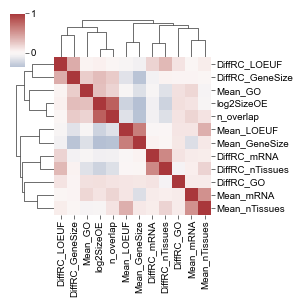

In [165]:
bio_feat = get_mean_diff_rc(bio_df, input_df, metrics= ['LOEUF', 'GO', 'GeneSize', 'mRNA', 'nTissues'])

### Network Features

In [166]:
use_net = net_df.loc[~net_df.varset.isin(['subnetwork', 'overlap']), ('trait_pair', 'subnetwork_density', 'assortativity', 'varset')]
use_net = use_net.pivot(index='trait_pair', columns='varset', values=['subnetwork_density', 'assortativity']).reset_index()

In [167]:
net_features = [['subnetwork_density', 'rare'], 'subnetwork_density-common', 'assortativity-rare_common']
net_feat = use_net.loc[:, [('trait_pair', ''), ('subnetwork_density', 'rare'), ('subnetwork_density', 'common'), ('assortativity', 'rare_common')]]
net_feat.columns=['trait_pair', 'subnetwork_density_rare', 'subnetwork_density_common', 'assortativity_rare_common']
net_feat = net_feat.set_index('trait_pair')

In [169]:
net_feat.columns=['density_R', 'density_C', 'assortativity_RC']

### Trait/Study Features

In [170]:
input_feat = input_df.loc[:, ['trait_pair', 'binary', 'jaccard', 'jaccard_zero', 'n_rare', 'n_common', 'N_C', 'N_R', 'log2SizeOE']].set_index('trait_pair')
input_feat.index.name=''

## Export Features

In [171]:
all_feat = net_feat.join(input_feat)

In [172]:
all_feat = all_feat.join(bio_feat.drop(columns=['n_overlap', 'log2SizeOE']))

In [173]:
all_feat.to_csv(os.path.join(datadir, 'outputs/regression_features2.txt'), sep='\t')

In [177]:
feature_names={
    'N_C': 'Study Size - Common',
    'N_R': "Study Size - Rare",
    'assortativity_RC':'Assortativity',
    'n_common': 'Number of Genes - Common',
    'n_rare': 'Number of Genes - Rare',
    'jaccard': 'Jaccard Sim.',
    'density_R': 'Subnetwork Density - Rare',
    'density_C': 'Subnetwork Density - Common',
    'binary': 'Is Trait Binary',
    'jaccard_zero': 'No shared genes', 
    'Mean_pli': 'Mean LOEUF', 
    'DiffRC_pli':'Diff. LOEUF', 
    'Mean_Length':'Mean Gene Size', 
    'DiffRC_Length':'Diff. Gene Size',
    'Mean_GO': 'Mean GO Terms', 
    'DiffRC_GO': 'Diff. GO Terms', 
    'Mean_mrna': 'Mean Exp.', 
    'DiffRC_mrna': 'Diff. Exp.', 
    'Mean_n_mrna': 'Mean Exp. Tissues',
    'DiffRC_n_mrna': 'Diff. Exp. Tissues'}

In [178]:
plot_feat = all_feat.rename(columns=feature_names)

## SFig 2A - Feature Correlations

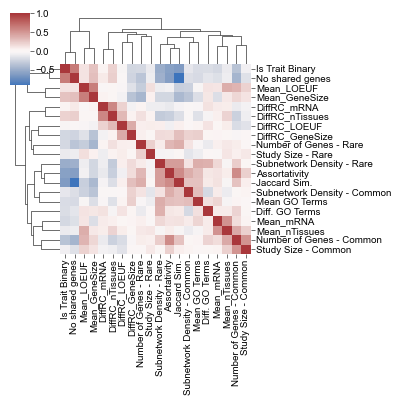

In [179]:
sns.clustermap(plot_feat.drop(columns='log2SizeOE').corr(method='spearman'), figsize=(4,4), cmap='vlag', center=0)
#plt.savefig(os.path.join(figdir, 'input_network_feature_correlations2.svg'), bbox_inches='tight')